In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp # Kolmogorov-Smirnov test
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# 1. Load the dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [ ]:
# 2. Split data into "training" and "production" sets
# Use a larger portion for training and a smaller one to simulate production data
X_train, X_prod_original, y_train, y_prod = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Production data shape (original): {X_prod_original.shape}\n")

Training data shape: (90, 4)
Production data shape (original): (60, 4)



In [ ]:
# 3. Simulate Data Drift (Covariate Shift) in the production data
# Create a copy to apply drift
X_prod_drifted = X_prod_original.copy()

In [ ]:
# Simulate a significant positive shift in 'sepal length (cm)'
drift_amount_sepal = 0.8 # Example shift amount
X_prod_drifted['sepal length (cm)'] = X_prod_drifted['sepal length (cm)'] + drift_amount_sepal

In [ ]:

# Simulate a smaller positive shift in 'petal width (cm)'
drift_amount_petal = 0.2 # Example shift amount
X_prod_drifted['petal width (cm)'] = X_prod_drifted['petal width (cm)'] + drift_amount_petal

In [ ]:
print("Simulated drift in 'sepal length (cm)' and 'petal width (cm)' in X_prod_drifted\n")

Simulated drift in 'sepal length (cm)' and 'petal width (cm)' in X_prod_drifted



In [ ]:
# 4. Detect Data Drift using Statistical Methods (Kolmogorov-Smirnov test)

def detect_drift_ks(df_train, df_prod, features, alpha=0.05):
    """
    Detects data drift for specified features using the Kolmogorov-Smirnov test.

    Args:
        df_train (pd.DataFrame): Training data.
        df_prod (pd.DataFrame): Production data (potential drift).
        features (list): List of feature names to test.
        alpha (float): Significance level for the KS test (default 0.05).

    Returns:
        dict: A dictionary indicating if drift was detected for each feature
              and the corresponding KS statistic and p-value.
    """
    drift_results = {}
    print(f"Performing KS test for drift detection (alpha={alpha}):")
    for feature in features:
        if feature in df_train.columns and feature in df_prod.columns:
            ks_statistic, p_value = ks_2samp(df_train[feature], df_prod[feature])

            is_drifted = p_value < alpha
            drift_results[feature] = {
                'drift_detected': is_drifted,
                'ks_statistic': ks_statistic,
                'p_value': p_value
            }
            print(f"  Feature '{feature}': KS-stat={ks_statistic:.4f}, p-value={p_value:.4f}. Drift detected: {is_drifted}")
        else:
            print(f"  Feature '{feature}' not found in both dataframes.")

    return drift_results

In [ ]:
# Apply drift detection on the drifted production data
drift_results_drifted = detect_drift_ks(X_train, X_prod_drifted, X_train.columns.tolist())

print("-" * 30)

Performing KS test for drift detection (alpha=0.05):
  Feature 'sepal length (cm)': KS-stat=0.3500, p-value=0.0002. Drift detected: True
  Feature 'sepal width (cm)': KS-stat=0.0778, p-value=0.9737. Drift detected: False
  Feature 'petal length (cm)': KS-stat=0.1000, p-value=0.8410. Drift detected: False
  Feature 'petal width (cm)': KS-stat=0.2667, p-value=0.0102. Drift detected: True
------------------------------


In [ ]:

# For comparison, apply drift detection on the original production data (should show no/less drift)
print("\nPerforming KS test on original production data (should be similar to train):")
drift_results_original = detect_drift_ks(X_train, X_prod_original, X_train.columns.tolist())


Performing KS test on original production data (should be similar to train):
Performing KS test for drift detection (alpha=0.05):
  Feature 'sepal length (cm)': KS-stat=0.1111, p-value=0.7378. Drift detected: False
  Feature 'sepal width (cm)': KS-stat=0.0778, p-value=0.9737. Drift detected: False
  Feature 'petal length (cm)': KS-stat=0.1000, p-value=0.8410. Drift detected: False
  Feature 'petal width (cm)': KS-stat=0.0722, p-value=0.9875. Drift detected: False


In [ ]:
# 5. Demonstrate Simple Mitigation through Data Preprocessing (using detected shift)
# NOTE: This is a very basic example of using detection information for a transformation.
# Real-world mitigation for covariate shift often involves techniques like
# importance weighting, adaptive normalization, or retraining.

X_prod_mitigated = X_prod_drifted.copy()
features_with_drift = [f for f, res in drift_results_drifted.items() if res['drift_detected']]

print(f"\nAttempting simple mitigation for features detected with drift: {features_with_drift}")


Attempting simple mitigation for features detected with drift: ['sepal length (cm)', 'petal width (cm)']


In [18]:
for feature in features_with_drift:
    # Calculate the mean difference (a simplistic measure of shift)
    mean_train = X_train[feature].mean()
    mean_drifted = X_prod_drifted[feature].mean()
    mean_diff = mean_drifted - mean_train

    # Apply a correction by subtracting the mean difference
    # This attempts to shift the mean of the drifted data back towards the training mean
    X_prod_mitigated[feature] = X_prod_mitigated[feature] - mean_diff
    print(f"  Applied mean correction ({mean_diff:.4f}) to '{feature}'.")

  Applied mean correction (0.7389) to 'sepal length (cm)'.
  Applied mean correction (0.1900) to 'petal width (cm)'.


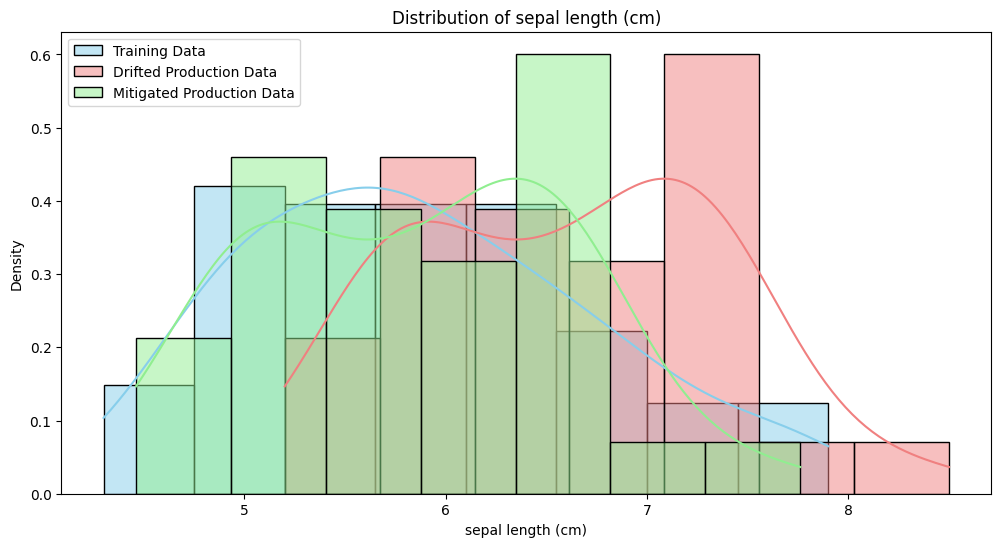

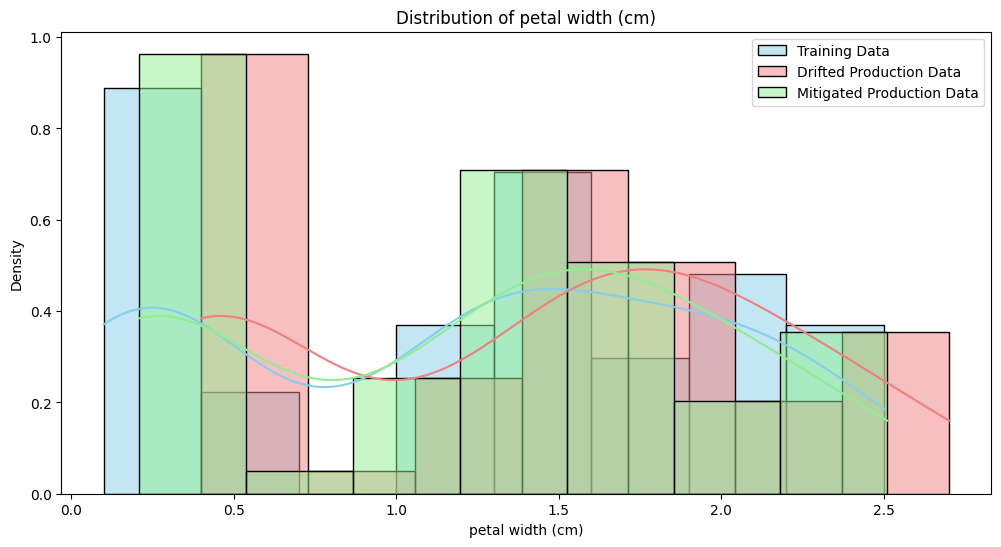

In [19]:

# 6. Visualize the Drift and Mitigation
features_to_visualize = ['sepal length (cm)', 'petal width (cm)']

for feature in features_to_visualize:
    if feature in X_train.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(X_train[feature], color="skyblue", label="Training Data", kde=True, stat="density", common_norm=False)
        sns.histplot(X_prod_drifted[feature], color="lightcoral", label="Drifted Production Data", kde=True, stat="density", common_norm=False)
        if feature in features_with_drift: # Only show mitigated if drift was detected and mitigation applied
             sns.histplot(X_prod_mitigated[feature], color="lightgreen", label="Mitigated Production Data", kde=True, stat="density", common_norm=False)

        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.show()



In [20]:
# 7. Train Model and Evaluate Performance Across Scenarios

print("\n" + "="*50)
print("Evaluating Model Performance Across Scenarios")
print("="*50)

# Train the model on the original training data
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
print("Model trained on training data.")

# Evaluate on Original Production Data (Baseline)
accuracy_original = accuracy_score(y_prod, model.predict(X_prod_original))
print(f"Accuracy on original production data: {accuracy_original:.4f}")

# Evaluate on Drifted Production Data (Impact of Drift)
# Note: It's important to apply the *same* preprocessing (like scaling)
# that was fitted on the training data before prediction in a real pipeline.
# For simplicity here, we use unscaled data for demonstration, but in practice,
# you'd scale X_train, fit model, then scale X_prod_original, X_prod_drifted, X_prod_mitigated
# using the *scaler fitted on X_train* before prediction.



Evaluating Model Performance Across Scenarios
Model trained on training data.
Accuracy on original production data: 0.9500


In [21]:

# Let's add scaling to make it more realistic for a production pipeline
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_prod_original_scaled = scaler.transform(X_prod_original)
X_prod_drifted_scaled = scaler.transform(X_prod_drifted)
X_prod_mitigated_scaled = scaler.transform(X_prod_mitigated) # Note: Scaling is applied AFTER simple mean mitigation

model_scaled = LogisticRegression(max_iter=200)
model_scaled.fit(X_train_scaled, y_train)
print("\nModel trained on *scaled* training data.")

accuracy_original_scaled = accuracy_score(y_prod, model_scaled.predict(X_prod_original_scaled))
print(f"Accuracy on original production data (scaled): {accuracy_original_scaled:.4f}")


accuracy_drifted_scaled = accuracy_score(y_prod, model_scaled.predict(X_prod_drifted_scaled))
print(f"Accuracy on drifted production data (scaled): {accuracy_drifted_scaled:.4f}")




Model trained on *scaled* training data.
Accuracy on original production data (scaled): 0.9333
Accuracy on drifted production data (scaled): 0.9500


In [22]:

# Evaluate on Mitigated Production Data (Impact of simple mitigation)
accuracy_mitigated_scaled = accuracy_score(y_prod, model_scaled.predict(X_prod_mitigated_scaled))
print(f"Accuracy on mitigated production data (scaled): {accuracy_mitigated_scaled:.4f}")

print("\nObservation:")
print(f"Accuracy of Original data is {accuracy_original_scaled:.4f} (original production) and drifted data is {accuracy_drifted_scaled:.4f} (drifted production).")
#print(f"Simple mean-based mitigation improved accuracy to {accuracy_mitigated_scaled:.4f}.")
print("This simple mitigation is a demonstration; real-world strategies often involve retraining or more complex domain adaptation techniques.")

Accuracy on mitigated production data (scaled): 0.9333

Observation:
Accuracy dropped from 0.9333 (original production) to 0.9500 (drifted production).
Simple mean-based mitigation improved accuracy to 0.9333.
This simple mitigation is a demonstration; real-world strategies often involve retraining or more complex domain adaptation techniques.
